<a href="https://colab.research.google.com/github/SahilKhan101/IPL-Data-Analysis/blob/main/WiDS_IPL_DL_Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Necessary Libraries & Modules

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math,os
from numpy.random import choice
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

In [4]:
from sklearn.linear_model import LinearRegression,Ridge,SGDRegressor,ElasticNet
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.validation import check_array 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from sklearn.svm import LinearSVR, SVC, SVR
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,ExtraTreesRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor

In [5]:
import torch
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torch.nn.functional as F

In [6]:
from google.colab import drive
drive.mount

<function google.colab.drive.mount>

# **Regression Task using PyTorch**

In [ ]:
!cp /content/drive/MyDrive/WiDS_IPL/ipl_data.csv .

In [ ]:
# importing the data cleaned during ML Task.
ipl_data = pd.read_csv('ipl_data.csv')
useful_cols = ['over','batsman_runs','total_runs_y','cumsum_runs','cumsum_wickets','total_runs_x']
ipl_data = ipl_data[useful_cols]

In [ ]:
df_train = ipl_data.loc[ipl_data['over']<=18.3]
df_test = ipl_data.loc[ipl_data['over']>18.3]

x = df_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_fit = min_max_scaler.fit(x)
print(min_max_scaler.data_max_)
x_scaled = min_max_scaler.fit_transform(x)
df_train = pd.DataFrame(x_scaled, columns=['1st', '2nd', '3rd', '4th', '5th', 'label'])
# df_train.rename(columns = {'5':'label'}, inplace = True)
display(df_train.head())

x = df_test.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_test = pd.DataFrame(x_scaled, columns=['1st', '2nd', '3rd', '4th', '5th', 'label'])
# df_test.rename(columns = {'5':'label'}, inplace = True)
display(df_test.head())

print('Size of training data :', df_train.shape[0])
print('Size of test data :', df_test.shape[0])

[ 18.3   6.    7.  245.   10.  263. ]


,1st,2nd,3rd,4th,5th,label
0,0.000000,0.0,0.142857,0.004082,0.0,0.812785
1,0.005495,0.0,0.000000,0.004082,0.0,0.812785
2,0.010989,0.0,0.142857,0.008163,0.0,0.812785
3,0.016484,0.0,0.000000,0.008163,0.0,0.812785
4,0.021978,0.0,0.000000,0.008163,0.0,0.812785


,1st,2nd,3rd,4th,5th,label
0,0.000000,0.666667,0.571429,0.643979,0.222222,0.775956
1,0.066667,0.166667,0.142857,0.649215,0.222222,0.775956
2,0.133333,0.666667,0.571429,0.670157,0.222222,0.775956
3,0.466667,1.000000,0.857143,0.701571,0.222222,0.775956
4,0.533333,1.000000,0.857143,0.732984,0.222222,0.775956


Size of training data : 181409
Size of test data : 11687


In [ ]:
class CustomDatasetFromCSV(Dataset):
    def __init__(self, data, transform=None):
        self.data = data 
        self.transforms = transforms
        self.to_tensor = transforms.ToTensor()

    def __getitem__(self, index):
        target = self.data.iloc[index,-1]
        data_val = self.data.iloc[index,:-1]
        target = torch.tensor(target,dtype=torch.float32)
        data_val = torch.tensor(data_val,dtype=torch.float32) 
        return data_val,target

    def __len__(self):
        return len(self.data)


dataset_trainval = CustomDatasetFromCSV(df_train)
dataset_test = CustomDatasetFromCSV(df_test)
batch_size = 128
validation_split = 0.075
#test_split = .15
shuffle_dataset = True
random_seed= 42

dataset_size = len(dataset_trainval)
indices = list(range(dataset_size))
split = int(np.floor((validation_split) * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset_trainval, batch_size=batch_size, 
                                           sampler=train_sampler,drop_last=True)
validation_loader = torch.utils.data.DataLoader(dataset_trainval, batch_size=batch_size,
                                                sampler=valid_sampler,drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=128,
                                                drop_last=True)

In [ ]:
class mymodel(torch.nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, H5, H6, D_out):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(mymodel, self).__init__()
        # self.input_linear = torch.nn.Linear(D_in, H)
        # self.output_linear = torch.nn.Linear(H, D_out)
        self.linear1 = nn.Linear(D_in, H1)
        self.norm1 = nn.BatchNorm1d(H1)
        self.linear2 = nn.Linear(H1, H2)
        self.norm2 = nn.BatchNorm1d(H2)
        self.linear3 = nn.Linear(H2, H3)
        self.norm3 = nn.BatchNorm1d(H3)
        self.linear4 = nn.Linear(H3, H4)
        self.norm4 = nn.BatchNorm1d(H4)
        self.linear5 = nn.Linear(H4, H5)
        self.linear6 = nn.Linear(H5, H6)
        self.linear7 = nn.Linear(H6, D_out)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.leaky_relu(self.norm1(self.linear1(x)))
        x = F.leaky_relu(self.norm2(self.linear2(x)))
        x = F.leaky_relu(self.norm3(self.linear3(x)))
        x = F.leaky_relu(self.norm4(self.linear4(x)))
        x = F.leaky_relu(self.linear5(x))
        x = F.leaky_relu(self.linear6(x))
        x = self.linear7(x)
        #print(x.shape[0])
        return x.view(batch_size)
        # x = x.view(x.shape[0])
        # return x    

In [ ]:
D_in, H1, H2, H3, H4, H5, H6, D_out = 5, 64, 128, 256, 128, 128, 64, 1

In [ ]:
print(len(train_loader))
print(len(validation_loader))
print(len(test_loader))

1310
106
91


In [ ]:
def custom_accuracy(y_test,y_pred,thresold=10):
    right = 0
    l = len(y_pred)
    for i in range(0,l):
        if(abs(y_pred[i]-y_test[i]) <= thresold):
            right += 1
    return (right)

def mean_absolute_percentage_error(y_true, y_pred):

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def r2(y_true,y_pred):
    return roundup(r2_score(y_true,y_pred))

def mse(y_true,y_pred):
    return roundup(mean_squared_error(y_true,y_pred))

def mae(y_true,y_pred):
    return roundup(mean_absolute_error(y_true,y_pred))

def mape(y_true, y_pred):
    return roundup(mean_absolute_percentage_error(y_true,y_pred))

def roundup(a, digits=4):
    n = 10**-digits
    return round(math.ceil(a / n) * n, digits)

def isEven(num):
    if num%2 ==0:
        return True
    return False

def modLog(num):
    try:
        return log(num)
    except:
        return 0

def loadNumpy(name,path='.'):
    if ".npy" in name:
        fullPath = path+'/'+name
    else:
        fullPath = path+'/'+name+'.npy'
    return np.load(fullPath, allow_pickle=True)

## Model summary of NN

In [ ]:
model = mymodel(D_in, H1, H2, H3, H4, H5, H6, D_out)
print(model)
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
if torch.cuda.is_available():
    model.to('cuda')

mymodel(
  (linear1): Linear(in_features=5, out_features=64, bias=True)
  (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=64, out_features=128, bias=True)
  (norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=128, out_features=256, bias=True)
  (norm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear4): Linear(in_features=256, out_features=128, bias=True)
  (norm4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear5): Linear(in_features=128, out_features=128, bias=True)
  (linear6): Linear(in_features=128, out_features=64, bias=True)
  (linear7): Linear(in_features=64, out_features=1, bias=True)
)


## Number of trainable parameters

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 100,609 trainable parameters


## Training the Model

In [ ]:
%%time
step = 0
epochs = 200
train_loss_list = []
valid_loss_list = []
train_acc_l = []
val_acc_l = []
validation_acc_l = []

for e in range(epochs):
    running_loss_train = 0 
    running_loss_valid = 0
    validation_r2 = 0
    train_r2 = 0


    for inputs, labels in train_loader:

        # Clear the gradients of all optimized tensors
        #print(inputs)
        #print(inputs,labels)
        optimizer.zero_grad()
        if torch.cuda.is_available():
            inputs, labels = inputs.to('cuda'), labels.to('cuda')   
        else:
            inputs, labels = input, labels        
        # Forward pass
        model.train()
        #print(type(inputs))
        outputs = model.forward(inputs)
        predicted = outputs.data
        #print(predicted,labels)
        #print(labels,predicted)
        #print(predicted,labels)
    
        #print(predicted,labels)

        #training_total += labels.size(0)
                
        train_loss = criterion(outputs, labels)
        train_r2_ =  r2(outputs.detach().cpu().numpy(), labels.detach().cpu().numpy())
        #training_correct += r2_loss
        
        #train_acc = training_correct
        # Backward pass
        train_loss.backward()
        optimizer.step()
        
        # Calculate and print running training loss
        running_loss_train += train_loss.item()  
        train_r2 +=  train_r2_
    validation_correct = 0
    validation_total = 0

        
    with torch.no_grad():    
            #count=0         
            # Iterate over the entire validation dataset
            for input_images2, labels2 in validation_loader:
                
                # Enable CUDA: use GPUs for model computation
                #count+=1
                #print(count)
                if torch.cuda.is_available():
                    input_images2, labels2 = input_images2.to('cuda'), labels2.to('cuda')
                
                # Make predictions 
                outputs2 = model.forward(input_images2)
                predicted2 = outputs2.data
                #print(predicted2,labels2)
                valid_r2_ =  r2(outputs2.detach().cpu().numpy(), labels2.detach().cpu().numpy())
                # Count total and correct predictions
                validation_total += labels2.size(0)
                validation_correct += custom_accuracy(labels2,predicted2,10/300)  
                #val_acc = custom_accuracy(labels2,predicted2)
                valid_loss = criterion(outputs2, labels2)
                # val_acc = validation_correct / validation_total
                running_loss_valid += valid_loss.item()  
                validation_r2 +=  valid_r2_

    val_acc = validation_correct / validation_total

    print("Epoch: {}/{}... ".format(e+1, epochs),
          "| Train Loss: {:.4f}".format(running_loss_train/len(train_loader)),
          "| Val Loss: {:.4f}".format(running_loss_valid/len(validation_loader)),
          "| Train R2: {:.4f}".format(train_r2/len(train_loader)),
          "| Val R2: {:.4f}".format(validation_r2/len(validation_loader)),
          "| Val Acc: {:.4f} %".format(val_acc*100))
    train_loss_list.append(running_loss_train/len(train_loader))
    valid_loss_list.append(running_loss_valid/len(validation_loader))
    train_acc_l.append(train_r2/len(train_loader))
    val_acc_l.append(validation_r2/len(validation_loader))
    validation_acc_l.append(val_acc*100)

          
    running_loss_train = 0
    running_loss_valid = 0

Epoch: 1/200...  | Train Loss: 0.0127 | Val Loss: 0.0116 | Train R2: -0.9308 | Val R2: -0.8758 | Val Acc: 29.0389 %
Epoch: 2/200...  | Train Loss: 0.0118 | Val Loss: 0.0116 | Train R2: -0.7324 | Val R2: -0.6936 | Val Acc: 28.3387 %
Epoch: 3/200...  | Train Loss: 0.0117 | Val Loss: 0.0114 | Train R2: -0.7079 | Val R2: -0.4267 | Val Acc: 29.5106 %
Epoch: 4/200...  | Train Loss: 0.0116 | Val Loss: 0.0114 | Train R2: -0.6944 | Val R2: -0.6745 | Val Acc: 29.1642 %
Epoch: 5/200...  | Train Loss: 0.0115 | Val Loss: 0.0114 | Train R2: -0.6921 | Val R2: -0.7017 | Val Acc: 29.3706 %
Epoch: 6/200...  | Train Loss: 0.0115 | Val Loss: 0.0114 | Train R2: -0.6928 | Val R2: -0.5612 | Val Acc: 28.8915 %
Epoch: 7/200...  | Train Loss: 0.0115 | Val Loss: 0.0114 | Train R2: -0.6799 | Val R2: -0.4179 | Val Acc: 29.5991 %
Epoch: 8/200...  | Train Loss: 0.0115 | Val Loss: 0.0113 | Train R2: -0.6690 | Val R2: -0.8950 | Val Acc: 29.2821 %
Epoch: 9/200...  | Train Loss: 0.0114 | Val Loss: 0.0116 | Train R2: -0.

KeyboardInterrupt: ignored

## Training and Validation accuracy and loss -V/S- Epochs

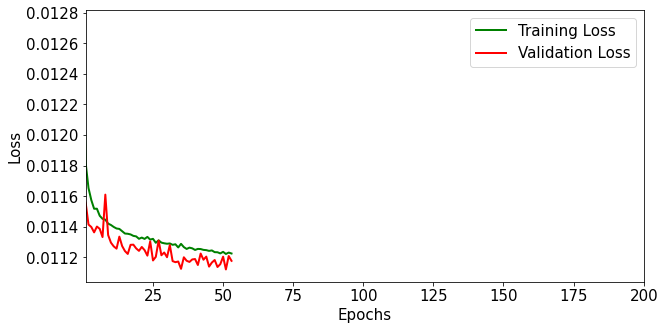

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,5))
# train_loss_list2 = [x/len(train_loader) for x in train_loss_list]
# valid_loss_list2 = [x/len(validation_loader) for x in valid_loss_list]
plt.plot(train_loss_list,c='g',label="Training Loss",linewidth=2)
plt.plot(valid_loss_list,c='r',label="Validation Loss",linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(1,200)
plt.legend()
plt.show()

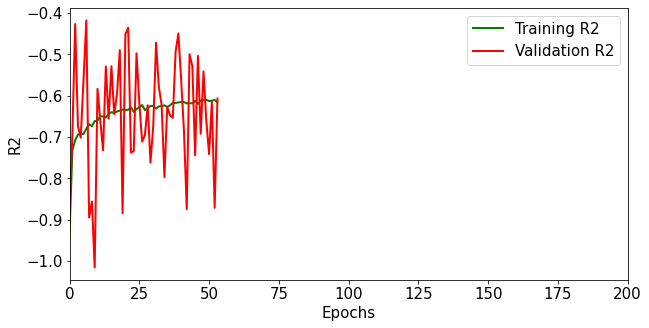

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,5))
# train_loss_list2 = [x/len(train_loader) for x in train_loss_list]
# valid_loss_list2 = [x/len(validation_loader) for x in valid_loss_list]
plt.plot(train_acc_l[0:],c='g',label="Training R2",linewidth=2)
plt.plot(val_acc_l[0:],c='r',label="Validation R2",linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.xlim(0,200)
plt.legend()
plt.show()

## Final Test Accuracy

In [ ]:
with torch.no_grad(): 
      model.eval()  
      test_total=0 
      test_correct=0
      for input_images3, labels3 in test_loader:

          if torch.cuda.is_available():
              input_images3, labels3 = input_images3.to('cuda'), labels3.to('cuda')
          
          outputs3= model.forward(input_images3)
          predicted3 = outputs3.data
          #print(predicted3, labels3)
          test_r2_ =  r2(outputs3.detach().cpu().numpy(), labels3.detach().cpu().numpy())
          test_total += labels3.size(0)
          test_correct += custom_accuracy(labels3,predicted2,40/300) 
          #print(test_correct)
          test_r2_ +=  test_r2_

In [ ]:
test_acc = test_correct/test_total*100
test_r2 = test_r2_/test_total
print(test_acc,test_r2)

54.112293956043956 0.00011974587912087912


## Saving the Progress and Model parameters

In [ ]:
path_to_checkpoint = '/content/drive/MyDrive/WiDS_IPL'

import os

def save_checkpoint(e):
  if not os.path.isdir(path_to_checkpoint):
    os.mkdir(path_to_checkpoint)
  torch.save({'e':e,'model': model.state_dict(), 'optim': optimizer.state_dict()}, os.path.join(path_to_checkpoint, 'checkpoint_reg_pytorch.pth'))

def save_progress_list(e):
  if not os.path.isdir(path_to_checkpoint):
    os.mkdir(path_to_checkpoint)
  torch.save({'e':e,'train_loss': train_loss_list, 'valid_loss': valid_loss_list, 'train_acc': train_acc_l, 'valid_acc': val_acc_l }, 
             os.path.join(path_to_checkpoint, 'progress_reg_pytorch.pth'))

def load_checkpoint(model1, optimizer1):
  if not os.path.isfile(os.path.join(path_to_checkpoint, 'checkpoint_reg_pytorch.pth')):
    return -1
  dic = torch.load(os.path.join(path_to_checkpoint, 'checkpoint_reg_pytorch.pth'))
  model1.load_state_dict(dic['model'])
  optimizer1.load_state_dict(dic['optim'])
  return dic['e']

def load_progress_list():
  if not os.path.isfile(os.path.join(path_to_checkpoint, 'progress_reg_pytorch.pth')):
    return -1
  dic = torch.load(os.path.join(path_to_checkpoint, 'progress_reg_pytorch.pth'))
  return dic['e'], dic['train_loss'], dic['valid_loss'], dic['train_acc'], dic['valid_acc']

In [ ]:
e=54
save_checkpoint(e)
save_progress_list(e)

In [ ]:
train_loss_list, valid_loss_list, train_acc_l, val_acc_l

# **Classification Task using PyTorch**

In [7]:
!cp /content/drive/MyDrive/WiDS_IPL/matches_prediction.csv .
df = pd.read_csv('matches_prediction.csv')
y = df['team1_win']
X = df.drop('team1_win', axis=1)

In [8]:
X.head()

,team1,team2,team1_toss_win,team1_bat,venue
0,13,12,0.0,1,28
1,8,11,0.0,1,21
2,4,7,0.0,1,31
3,11,5,0.0,1,13
4,12,3,1.0,1,17


In [9]:
y.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: team1_win, dtype: float64

In [85]:
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib
from tqdm import tqdm
import torch

from sklearn.datasets import make_classification
import matplotlib.pyplot as plt


# X_train, X_test, y_train,  y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42)

A, X_test, b, y_test = train_test_split(X,y,test_size=0.1,train_size=0.9, random_state=101)
X_train, X_final_test, y_train, y_final_test = train_test_split(A,b,test_size = 0.1/0.9,train_size =0.8/0.9, random_state=101)


class LogisticRegression(torch.nn.Module):
    # def __init__(self, input_dim, output_dim):
    def __init__(self, D_in, H1, H2, D_out):
        super(LogisticRegression, self).__init__()
        # self.linear = torch.nn.Linear(input_dim, output_dim)
        self.linear1 = nn.Linear(D_in, H1)
        self.norm1 = nn.BatchNorm1d(H1)
        self.linear2 = nn.Linear(H1, H2)
        self.norm2 = nn.BatchNorm1d(H2)
        self.linear7 = nn.Linear(H2, D_out)

    def forward(self, x):
        # outputs = torch.sigmoid(self.linear(x))
        x = F.leaky_relu(self.norm1(self.linear1(x)))
        x = F.leaky_relu(self.norm2(self.linear2(x)))
        x = self.linear7(x)
        outputs = torch.sigmoid(x)
        return outputs

epochs = 200
# input_dim = 5 # Two inputs x1 and x2 
# output_dim = 1 # Two possible outputs
D_in, H1, H2, D_out = 5, 32, 32, 1
learning_rate = 0.01

# model = LogisticRegression(input_dim,output_dim)
model = LogisticRegression(D_in, H1, H2, D_out)

criterion = torch.nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

X_train, X_test, X_final_test = torch.Tensor(X_train.values),torch.Tensor(X_test.values),torch.Tensor(X_final_test.values)
y_train, y_test, y_final_test = torch.Tensor(y_train.values),torch.Tensor(y_test.values),torch.Tensor(y_final_test.values)


## Model summary of NN

In [68]:
model

LogisticRegression(
  (linear1): Linear(in_features=5, out_features=32, bias=True)
  (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=32, out_features=32, bias=True)
  (norm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear7): Linear(in_features=32, out_features=1, bias=True)
)

##  Number of trainable parameters

In [86]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,409 trainable parameters


## Training the Model

In [87]:
losses_train = []
losses_test = []
acc_train = []
acc_test = []
Iterations = []
iter = 0
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train)
    loss = criterion(torch.squeeze(outputs), labels) # [200,1] -squeeze-> [200]
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter+=1
    # if iter%100==0:

      # calculate Accuracy
    with torch.no_grad():
        # Calculating the loss and accuracy for the test dataset
        correct_test = 0
        total_test = 0
        outputs_test = torch.squeeze(model(X_test))
        loss_test = criterion(outputs_test, y_test)
        
        predicted_test = outputs_test.round().detach().numpy()
        total_test = y_test.size(0)
        correct_test = np.sum(predicted_test == y_test.detach().numpy())
        accuracy_test = 100 * correct_test/total_test
        losses_test.append(loss_test.item())
        acc_test.append(accuracy_test)
        
        # Calculating the loss and accuracy for the train dataset
        total = 0
        correct = 0
        total = y_train.size(0)
        correct = np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
        accuracy = 100 * correct/total
        losses_train.append(loss.item())
        acc_train.append(accuracy)
        Iterations.append(iter)
        
        print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
        print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")


Training Epochs:  22%|██▎       | 45/200 [00:00<00:00, 446.36it/s]

Iteration: 1. 
Test - Loss: 0.7360618710517883. Accuracy: 47.36842105263158
Train -  Loss: 0.740829586982727. Accuracy: 46.166666666666664

Iteration: 2. 
Test - Loss: 0.7339992523193359. Accuracy: 47.36842105263158
Train -  Loss: 0.7389340400695801. Accuracy: 46.333333333333336

Iteration: 3. 
Test - Loss: 0.7320181727409363. Accuracy: 50.0
Train -  Loss: 0.737106204032898. Accuracy: 46.333333333333336

Iteration: 4. 
Test - Loss: 0.7301002144813538. Accuracy: 50.0
Train -  Loss: 0.7353514432907104. Accuracy: 46.5

Iteration: 5. 
Test - Loss: 0.7282471656799316. Accuracy: 50.0
Train -  Loss: 0.7336592674255371. Accuracy: 46.666666666666664

Iteration: 6. 
Test - Loss: 0.7264793515205383. Accuracy: 50.0
Train -  Loss: 0.7320306897163391. Accuracy: 46.833333333333336

Iteration: 7. 
Test - Loss: 0.7247790098190308. Accuracy: 50.0
Train -  Loss: 0.7304590940475464. Accuracy: 46.833333333333336

Iteration: 8. 
Test - Loss: 0.7231336832046509. Accuracy: 50.0
Train -  Loss: 0.72893679141998

Training Epochs:  64%|██████▍   | 129/200 [00:00<00:00, 358.96it/s]

Iteration: 85. 
Test - Loss: 0.6775389313697815. Accuracy: 61.8421052631579
Train -  Loss: 0.6894453167915344. Accuracy: 52.666666666666664

Iteration: 86. 
Test - Loss: 0.6773819327354431. Accuracy: 61.8421052631579
Train -  Loss: 0.6893340945243835. Accuracy: 52.833333333333336

Iteration: 87. 
Test - Loss: 0.6772314310073853. Accuracy: 61.8421052631579
Train -  Loss: 0.6892240643501282. Accuracy: 53.333333333333336

Iteration: 88. 
Test - Loss: 0.6770825386047363. Accuracy: 61.8421052631579
Train -  Loss: 0.689116895198822. Accuracy: 53.5

Iteration: 89. 
Test - Loss: 0.676941454410553. Accuracy: 61.8421052631579
Train -  Loss: 0.6890106201171875. Accuracy: 53.666666666666664

Iteration: 90. 
Test - Loss: 0.676801860332489. Accuracy: 61.8421052631579
Train -  Loss: 0.688906729221344. Accuracy: 53.833333333333336

Iteration: 91. 
Test - Loss: 0.6766683459281921. Accuracy: 61.8421052631579
Train -  Loss: 0.6888052821159363. Accuracy: 53.833333333333336

Iteration: 92. 
Test - Loss: 0.

Training Epochs: 100%|██████████| 200/200 [00:00<00:00, 340.15it/s]

Iteration: 152. 
Test - Loss: 0.6719708442687988. Accuracy: 60.526315789473685
Train -  Loss: 0.6850055456161499. Accuracy: 56.333333333333336

Iteration: 153. 
Test - Loss: 0.6719337701797485. Accuracy: 60.526315789473685
Train -  Loss: 0.6849634647369385. Accuracy: 56.333333333333336

Iteration: 154. 
Test - Loss: 0.6718958616256714. Accuracy: 60.526315789473685
Train -  Loss: 0.6849216818809509. Accuracy: 56.333333333333336

Iteration: 155. 
Test - Loss: 0.6718564033508301. Accuracy: 60.526315789473685
Train -  Loss: 0.6848800778388977. Accuracy: 56.333333333333336

Iteration: 156. 
Test - Loss: 0.6718190312385559. Accuracy: 60.526315789473685
Train -  Loss: 0.6848391890525818. Accuracy: 56.5

Iteration: 157. 
Test - Loss: 0.6717837452888489. Accuracy: 60.526315789473685
Train -  Loss: 0.684798538684845. Accuracy: 56.5

Iteration: 158. 
Test - Loss: 0.6717517375946045. Accuracy: 60.526315789473685
Train -  Loss: 0.6847578883171082. Accuracy: 56.5

Iteration: 159. 
Test - Loss: 0.671

##  Training and Validation accuracy and loss  -V/S-  Epochs 

In [88]:
def plot_model_progress(train_loss_list, valid_loss_list):
  plt.rcParams.update({'font.size': 15})
  plt.figure(figsize=(10,5))
  plt.plot(train_loss_list,c='g',label="Training Loss",linewidth=2)
  plt.plot(valid_loss_list,c='r',label="Validation Loss",linewidth=2)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.xlim(1,200)
  plt.legend()
  plt.show()

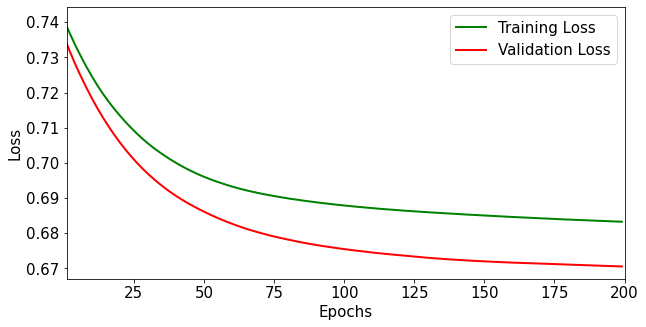

In [89]:
plot_model_progress(losses_train, losses_test)

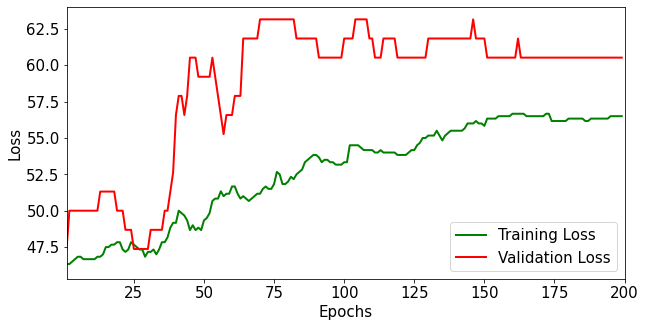

In [90]:
plot_model_progress(acc_train, acc_test)

## Final Test Accuracy

In [91]:
outputs_test = torch.squeeze(model(X_final_test))
loss_test = criterion(outputs_test, y_final_test)

predicted_test = outputs_test.round().detach().numpy()
total_test = y_final_test.size(0)
correct_test = np.sum(predicted_test == y_final_test.detach().numpy())
accuracy_final = 100 * correct_test/total_test
# losses_test.append(loss_test.item())
# acc_test.append(accuracy_test)
print(accuracy_final)

63.1578947368421
